# Performing parallel / batch processing of simulations

<img src="img/splitter.png" alt="diagram" width="400"/>

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

In this notebook, we will show an example of using tidy3d to evaluate device performance over a set of many design parameters.

This example will also provide a walkthrough of Tidy3D's [Job](../api/_autosummary/tidy3d.web.Job.html) and [Batch](../api/_autosummary/tidy3d.web.Batch.html) features for managing both individual simulations and sets of simulations.

> Note: as of version `1.8`, the [tidy3d.web.run_async](../api/_autosummary/tidy3d.web.run_async.html) function handles the same functionality as the batch, with a simpler syntax. As such, it could be a good alternative for parameter scan depending on how your script is set up.

Additionally, we will show how to do this problem using `tidy3d.plugins.design`, which provides convenience methods for defining and running parameter scans, which has a full tutorial [here](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/).

For demonstration, we look at the splitting ratio of a directional coupler as we vary the coupling length between two waveguides. The sidewall of the waveguides is slanted, deviating from the vertical direction by `sidewall_angle`.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gdstk

# tidy3D imports
import tidy3d as td
from tidy3d import web


## Setup

First we set up some global parameters

In [2]:
# wavelength / frequency
lambda0 = 1.550  # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 0.45
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# Reference plane where the cross section of the device is defined
reference_plane = "bottom"
# Angle of the sidewall deviating from the vertical ones, positive values for the base larger than the top
sidewall_angle = np.pi / 6
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# space between waveguide and PML
pml_spacing = 1
# resolution control: minimum number of grid cells per wavelength in each material
grid_cells_per_wvl = 16


### Define waveguide bends and coupler

Here is where we define our directional coupler shape programmatically in terms of the geometric parameters

In [3]:
def tanh_interp(max_arg):
    """Interpolator for tanh with adjustable extension"""
    scale = 1 / np.tanh(max_arg)
    return lambda u: 0.5 * (1 + scale * np.tanh(max_arg * (u * 2 - 1)))


def make_coupler(
    length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
):
    """Make an integrated coupler using the gdstk RobustPath object."""
    # bend interpolator
    interp = tanh_interp(3)
    delta = wg_width + wg_spacing_coup - wg_spacing_in
    offset = lambda u: wg_spacing_in + interp(u) * delta

    coup = gdstk.RobustPath(
        (-0.5 * length, 0),
        (wg_width, wg_width),
        wg_spacing_in,
        simple_path=True,
        layer=1,
        datatype=[0, 1],
    )
    coup.segment((-0.5 * coup_length - bend_length, 0))
    coup.segment(
        (-0.5 * coup_length, 0),
        offset=[lambda u: -0.5 * offset(u), lambda u: 0.5 * offset(u)],
    )
    coup.segment((0.5 * coup_length, 0))
    coup.segment(
        (0.5 * coup_length + bend_length, 0),
        offset=[lambda u: -0.5 * offset(1 - u), lambda u: 0.5 * offset(1 - u)],
    )
    coup.segment((0.5 * length, 0))
    return coup


### Create Simulation and Submit Job

The following function creates a tidy3d simulation object for a set of design parameters.

Note that the simulation has not been run yet, just created.

In [4]:
def make_sim(coup_length, wg_spacing_coup, domain_field=False):
    """Make a simulation with a given length of the coupling region and
    distance between the waveguides in that region. If ``domain_field``
    is True, a 2D in-plane field monitor will be added.
    """

    # Geometry must be placed in GDS cells to import into Tidy3D
    coup_cell = gdstk.Cell("Coupler")

    substrate = gdstk.rectangle(
        (-device_length / 2, -wg_spacing_in / 2 - 10),
        (device_length / 2, wg_spacing_in / 2 + 10),
        layer=0,
    )
    coup_cell.add(substrate)

    # Add the coupler to a gdstk cell
    gds_coup = make_coupler(
        device_length,
        wg_spacing_in,
        wg_width,
        wg_spacing_coup,
        coup_length,
        bend_length,
    )
    coup_cell.add(gds_coup)

    # Substrate
    (oxide_geo,) = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=0,
        gds_dtype=0,
        slab_bounds=(-10, 0),
        reference_plane=reference_plane,
        axis=2,
    )

    oxide = td.Structure(geometry=oxide_geo, medium=mat_sub)

    # Waveguides (import all datatypes if gds_dtype not specified)
    coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=1,
        slab_bounds=(0, wg_height),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
        axis=2,
    )

    coupler1 = td.Structure(geometry=coupler1_geo, medium=mat_wg)

    coupler2 = td.Structure(geometry=coupler2_geo, medium=mat_wg)

    # Simulation size along propagation direction
    sim_length = 2 + 2 * bend_length + coup_length

    # Spacing between waveguides and PML
    sim_size = [
        sim_length,
        wg_spacing_in + wg_width + 2 * pml_spacing,
        wg_height + 2 * pml_spacing,
    ]

    # source
    src_pos = -sim_length / 2 + 0.5
    msource = td.ModeSource(
        center=[src_pos, wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=td.ModeSpec(),
        mode_index=0,
    )

    mon_in = td.ModeMonitor(
        center=[(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name="in",
    )
    mon_ref_bot = td.ModeMonitor(
        center=[(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name="refect_bottom",
    )
    mon_top = td.ModeMonitor(
        center=[-(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name="top",
    )
    mon_bot = td.ModeMonitor(
        center=[-(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name="bottom",
    )
    monitors = [mon_in, mon_ref_bot, mon_top, mon_bot]

    if domain_field == True:
        domain_monitor = td.FieldMonitor(
            center=[0, 0, wg_height / 2],
            size=[td.inf, td.inf, 0],
            freqs=[freq0],
            name="field",
        )
        monitors.append(domain_monitor)

    # initialize the simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=grid_cells_per_wvl),
        structures=[oxide, coupler1, coupler2],
        sources=[msource],
        monitors=monitors,
        run_time=50 / fwidth,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    )

    return sim


## Inspect Simulation

Let's create and inspect a single simulation to make sure it was defined correctly before doing the full scan. The sidewalls of the waveguides deviate from the vertical direction by 30 degree. We also add an in-plane field monitor to have a look at the fields evolution in this one simulation. We will not use such a monitor in the batch to avoid storing unnecesarrily large amounts of data.

In [5]:
# Length of the coupling region
coup_length = 10

# Waveguide separation in the coupling region
wg_spacing_coup = 0.10

sim = make_sim(coup_length, wg_spacing_coup, domain_field=True)


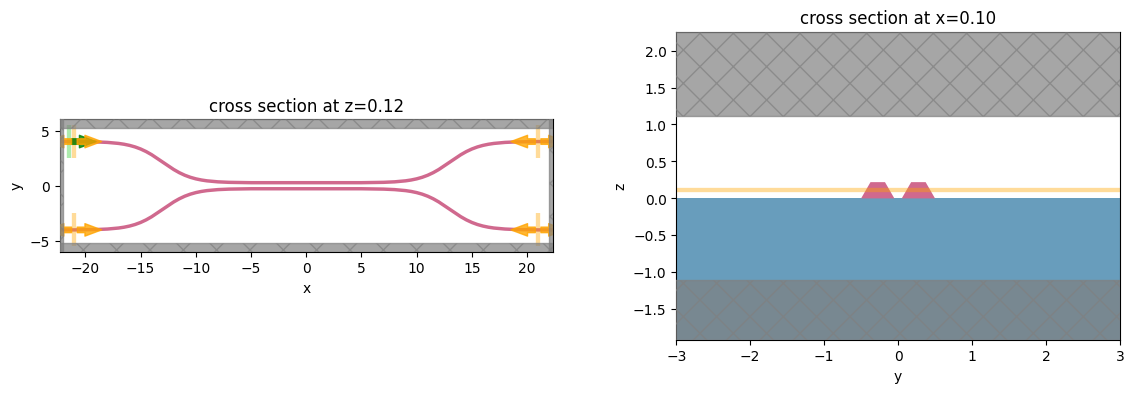

In [6]:
# visualize geometry
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sim.plot(z=wg_height / 2 + 0.01, ax=ax1)
sim.plot(x=0.1, ax=ax2)
ax2.set_xlim([-3, 3])
plt.show()


## Create and Submit Job

The [Job](../api/_autosummary/tidy3d.web.Job.html) object provides an interface for managing simulations.

`job = Job(simulation)` will create a job and upload the simulation to our server to run.

Then, one may call various methods of `job` to monitor progress, download results, and get information.

For more information, refer to the API reference.

In [7]:
# create job, upload sim to server to begin running
job = web.Job(simulation=sim, task_name="CouplerVerify", verbose=True)

# download the results and load them into a simulation
sim_data = job.run(path="data/sim_data.hdf5")


23:17:19 PST Created task 'CouplerVerify' with task_id                          
             'fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=608569;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=682550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\taskId]8;;\]8;id=608569;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\=]8;;\]8;id=217562;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\fdve]8;;\]8;id=608569;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\-bbfb4256-ac7]8;;\
             ]8;id=608569;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\b-48b8-b472-5a231c2f3828']8;;\.

Output()

23:17:21 PST status = queued

Output()

23:17:24 PST status = preprocess

23:17:26 PST Maximum FlexCredit cost: 0.588. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

23:18:57 PST early shutoff detected at 52%, exiting.

             status = postprocess

Output()

23:18:59 PST status = success

             View simulation result at                                          
             ]8;id=869715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=418572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\taskId]8;;\]8;id=869715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\=]8;;\]8;id=992599;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\fdve]8;;\]8;id=869715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\-bbfb4256-ac7]8;;\
             ]8;id=869715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bbfb4256-ac7b-48b8-b472-5a231c2f3828\b-48b8-b472-5a231c2f3828']8;;\.

Output()

23:19:01 PST loading simulation from data/sim_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

## Postprocessing

The following function takes a completed simulation (with data loaded into it) and computes the quantities of interest.

For this case, we measure both the total transmission in the right ports and also the ratio of power between the top and bottom ports.

In [8]:
def measure_transmission(sim_data):
    """Constructs a "row" of the scattering matrix when sourced from top left port"""

    input_amp = sim_data["in"].amps.sel(direction="+")

    amps = np.zeros(4, dtype=complex)
    directions = ("-", "-", "+", "+")
    for i, (monitor, direction) in enumerate(
        zip(sim_data.simulation.monitors[:4], directions)
    ):
        amp = sim_data[monitor.name].amps.sel(direction=direction)
        amp_normalized = amp / input_amp
        amps[i] = np.squeeze(amp_normalized.values)

    return amps


In [9]:
# monitor and test out the measure_transmission function the results of the single run
amps_arms = measure_transmission(sim_data)
print("mode amplitudes in each port:\n")
for amp, monitor in zip(amps_arms, sim_data.simulation.monitors[:-1]):
    print(f'\tmonitor     = "{monitor.name}"')
    print(f"\tamplitude^2 = {abs(amp)**2:.2f}")
    print(f"\tphase       = {(np.angle(amp)):.2f} (rad)\n")


23:19:03 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

mode amplitudes in each port:

	monitor     = "in"
	amplitude^2 = 0.00
	phase       = -2.01 (rad)

	monitor     = "refect_bottom"
	amplitude^2 = 0.00
	phase       = 0.76 (rad)

	monitor     = "top"
	amplitude^2 = 0.95
	phase       = -0.37 (rad)

	monitor     = "bottom"
	amplitude^2 = 0.04
	phase       = 1.20 (rad)



             WARNING: 'freq' supplied to 'plot_field', frequency selection key  
             renamed to 'f' and 'freq' will error in future release, please     
             update your local script to use 'f=value'.                         

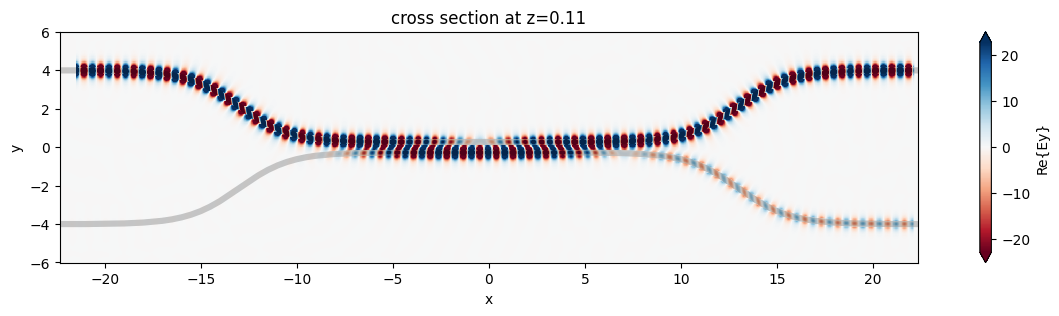

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
sim_data.plot_field("field", "Ey", z=wg_height / 2, freq=freq0, ax=ax)
plt.show()


## 1D Parameter Scan

Now we will scan through the coupling length parameter to see the effect on splitting ratio.

To do this, we will create a list of simulations corresponding to each parameter combination.

We will use this list to create a [Batch](../api/_autosummary/tidy3d.web.Batch.html) object, which has similar functionality to [Job](../api/_autosummary/tidy3d.web.Job.html) but allows one to manage a *set* of jobs.

First, we create arrays to store the input and output values.

In [11]:
# create variables to store parameters, simulation information, results
Nl = 11

ls = np.linspace(5, 12, Nl)
split_ratios = np.zeros(Nl)
efficiencies = np.zeros(Nl)


### Create Batch

We now create our list of simulations and use them to initialize a [Batch](../api/_autosummary/tidy3d.web.Batch.html).

For more information, refer to the API reference.

In [12]:
# submit all jobs
sims = {f"l={l:.2f}": make_sim(l, wg_spacing_coup) for l in ls}
batch = web.Batch(simulations=sims, verbose=True)


23:19:05 PST Created task 'l=5.00' with task_id                                 
             'fdve-e4585e49-5b5a-41e4-9481-a9c5808b451c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=960204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e4585e49-5b5a-41e4-9481-a9c5808b451c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=842875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e4585e49-5b5a-41e4-9481-a9c5808b451c\taskId]8;;\]8;id=960204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e4585e49-5b5a-41e4-9481-a9c5808b451c\=]8;;\]8;id=206920;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e4585e49-5b5a-41e4-9481-a9c5808b451c\fdve]8;;\]8;id=960204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e4585e49-5b5a-41e4-9481-a9c5808b451c\-e4585e49-5b5]8;;\
             ]8;id=960204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e4585e49-5b5a-41e4-9481-a9c5808b451c\a-41e4-9481-a9c5808b451c']8;;\.

Output()

             Created task 'l=5.70' with task_id                                 
             'fdve-ee93f76f-0834-44b2-9d17-44b1af51e0fb' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=129468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee93f76f-0834-44b2-9d17-44b1af51e0fb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=96856;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee93f76f-0834-44b2-9d17-44b1af51e0fb\taskId]8;;\]8;id=129468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee93f76f-0834-44b2-9d17-44b1af51e0fb\=]8;;\]8;id=972865;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee93f76f-0834-44b2-9d17-44b1af51e0fb\fdve]8;;\]8;id=129468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee93f76f-0834-44b2-9d17-44b1af51e0fb\-ee93f76f-083]8;;\
             ]8;id=129468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ee93f76f-0834-44b2-9d17-44b1af51e0fb\4-44b2-9d17-44b1af51e0fb']8;;\.

Output()

23:19:06 PST Created task 'l=6.40' with task_id                                 
             'fdve-99bed8ce-2a64-4c33-979c-f5938a93aa82' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=132807;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99bed8ce-2a64-4c33-979c-f5938a93aa82\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=812870;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99bed8ce-2a64-4c33-979c-f5938a93aa82\taskId]8;;\]8;id=132807;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99bed8ce-2a64-4c33-979c-f5938a93aa82\=]8;;\]8;id=687116;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99bed8ce-2a64-4c33-979c-f5938a93aa82\fdve]8;;\]8;id=132807;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99bed8ce-2a64-4c33-979c-f5938a93aa82\-99bed8ce-2a6]8;;\
             ]8;id=132807;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99bed8ce-2a64-4c33-979c-f5938a93aa82\4-4c33-979c-f5938a93aa82']8;;\.

Output()

             Created task 'l=7.10' with task_id                                 
             'fdve-c417fef8-8c75-483e-853d-66e097e64501' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=370529;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c417fef8-8c75-483e-853d-66e097e64501\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=150375;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c417fef8-8c75-483e-853d-66e097e64501\taskId]8;;\]8;id=370529;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c417fef8-8c75-483e-853d-66e097e64501\=]8;;\]8;id=658720;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c417fef8-8c75-483e-853d-66e097e64501\fdve]8;;\]8;id=370529;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c417fef8-8c75-483e-853d-66e097e64501\-c417fef8-8c7]8;;\
             ]8;id=370529;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c417fef8-8c75-483e-853d-66e097e64501\5-483e-853d-66e097e64501']8;;\.

Output()

23:19:07 PST Created task 'l=7.80' with task_id                                 
             'fdve-17239d3f-056a-4990-83ef-ffb99ffc804c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=478463;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17239d3f-056a-4990-83ef-ffb99ffc804c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=166146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17239d3f-056a-4990-83ef-ffb99ffc804c\taskId]8;;\]8;id=478463;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17239d3f-056a-4990-83ef-ffb99ffc804c\=]8;;\]8;id=446229;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17239d3f-056a-4990-83ef-ffb99ffc804c\fdve]8;;\]8;id=478463;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17239d3f-056a-4990-83ef-ffb99ffc804c\-17239d3f-056]8;;\
             ]8;id=478463;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17239d3f-056a-4990-83ef-ffb99ffc804c\a-4990-83ef-ffb99ffc804c']8;;\.

Output()

23:19:23 PST Created task 'l=8.50' with task_id                                 
             'fdve-590a6d71-b2cd-41be-a825-c4ec2124b97a' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=909048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-590a6d71-b2cd-41be-a825-c4ec2124b97a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=643334;https://tidy3d.simulation.cloud/workbench?taskId=fdve-590a6d71-b2cd-41be-a825-c4ec2124b97a\taskId]8;;\]8;id=909048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-590a6d71-b2cd-41be-a825-c4ec2124b97a\=]8;;\]8;id=176742;https://tidy3d.simulation.cloud/workbench?taskId=fdve-590a6d71-b2cd-41be-a825-c4ec2124b97a\fdve]8;;\]8;id=909048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-590a6d71-b2cd-41be-a825-c4ec2124b97a\-590a6d71-b2c]8;;\
             ]8;id=909048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-590a6d71-b2cd-41be-a825-c4ec2124b97a\d-41be-a825-c4ec2124b97a']8;;\.

Output()

             Created task 'l=9.20' with task_id                                 
             'fdve-35cdb1b2-1365-4ce8-87c7-50544fdba103' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=34511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35cdb1b2-1365-4ce8-87c7-50544fdba103\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=917149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35cdb1b2-1365-4ce8-87c7-50544fdba103\taskId]8;;\]8;id=34511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35cdb1b2-1365-4ce8-87c7-50544fdba103\=]8;;\]8;id=410776;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35cdb1b2-1365-4ce8-87c7-50544fdba103\fdve]8;;\]8;id=34511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35cdb1b2-1365-4ce8-87c7-50544fdba103\-35cdb1b2-136]8;;\
             ]8;id=34511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35cdb1b2-1365-4ce8-87c7-50544fdba103\5-4ce8-87c7-50544fdba103']8;;\.

Output()

23:19:24 PST Created task 'l=9.90' with task_id                                 
             'fdve-976fc437-a996-4ebe-aaa4-015a23d65d01' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=72641;https://tidy3d.simulation.cloud/workbench?taskId=fdve-976fc437-a996-4ebe-aaa4-015a23d65d01\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=56055;https://tidy3d.simulation.cloud/workbench?taskId=fdve-976fc437-a996-4ebe-aaa4-015a23d65d01\taskId]8;;\]8;id=72641;https://tidy3d.simulation.cloud/workbench?taskId=fdve-976fc437-a996-4ebe-aaa4-015a23d65d01\=]8;;\]8;id=989078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-976fc437-a996-4ebe-aaa4-015a23d65d01\fdve]8;;\]8;id=72641;https://tidy3d.simulation.cloud/workbench?taskId=fdve-976fc437-a996-4ebe-aaa4-015a23d65d01\-976fc437-a99]8;;\
             ]8;id=72641;https://tidy3d.simulation.cloud/workbench?taskId=fdve-976fc437-a996-4ebe-aaa4-015a23d65d01\6-4ebe-aaa4-015a23d65d01']8;;\.

Output()

             Created task 'l=10.60' with task_id                                
             'fdve-da48abd6-b784-4d9a-9491-436ee9cbe172' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=621399;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da48abd6-b784-4d9a-9491-436ee9cbe172\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=254222;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da48abd6-b784-4d9a-9491-436ee9cbe172\taskId]8;;\]8;id=621399;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da48abd6-b784-4d9a-9491-436ee9cbe172\=]8;;\]8;id=111734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da48abd6-b784-4d9a-9491-436ee9cbe172\fdve]8;;\]8;id=621399;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da48abd6-b784-4d9a-9491-436ee9cbe172\-da48abd6-b78]8;;\
             ]8;id=621399;https://tidy3d.simulation.cloud/workbench?taskId=fdve-da48abd6-b784-4d9a-9491-436ee9cbe172\4-4d9a-9491-436ee9cbe172']8;;\.

Output()

             Created task 'l=11.30' with task_id                                
             'fdve-96bb8c32-7574-4ebc-8d40-7295d81ab5da' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=599552;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96bb8c32-7574-4ebc-8d40-7295d81ab5da\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=420877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96bb8c32-7574-4ebc-8d40-7295d81ab5da\taskId]8;;\]8;id=599552;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96bb8c32-7574-4ebc-8d40-7295d81ab5da\=]8;;\]8;id=364308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96bb8c32-7574-4ebc-8d40-7295d81ab5da\fdve]8;;\]8;id=599552;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96bb8c32-7574-4ebc-8d40-7295d81ab5da\-96bb8c32-757]8;;\
             ]8;id=599552;https://tidy3d.simulation.cloud/workbench?taskId=fdve-96bb8c32-7574-4ebc-8d40-7295d81ab5da\4-4ebc-8d40-7295d81ab5da']8;;\.

Output()

23:19:25 PST Created task 'l=12.00' with task_id                                
             'fdve-406814c9-7830-47d6-9295-843ccbeb7bca' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=499991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-406814c9-7830-47d6-9295-843ccbeb7bca\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=652655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-406814c9-7830-47d6-9295-843ccbeb7bca\taskId]8;;\]8;id=499991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-406814c9-7830-47d6-9295-843ccbeb7bca\=]8;;\]8;id=94473;https://tidy3d.simulation.cloud/workbench?taskId=fdve-406814c9-7830-47d6-9295-843ccbeb7bca\fdve]8;;\]8;id=499991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-406814c9-7830-47d6-9295-843ccbeb7bca\-406814c9-783]8;;\
             ]8;id=499991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-406814c9-7830-47d6-9295-843ccbeb7bca\0-47d6-9295-843ccbeb7bca']8;;\.

Output()

### Monitor Batch

Here we can perform real-time monitoring of how many of the jobs in the batch have completed.

In [13]:
batch_results = batch.run(path_dir="data")


23:19:32 PST Started working on Batch.

23:19:36 PST Maximum FlexCredit cost: 6.251 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

23:23:27 PST Batch complete.

### Load and visualize Results

Finally, we can compute the output quantities and load them into the arrays we created initally.

Then we may plot the results.

In [14]:
amps_batch = []
for task_name, sim_data in batch_results.items():
    amps_arms_i = np.array(measure_transmission(sim_data))
    amps_batch.append(amps_arms_i)
amps_batch = np.stack(amps_batch, axis=1)
print(amps_batch.shape)  # (4, Nl)
print(amps_batch)


Output()

23:23:31 PST loading simulation from                                            
             data/fdve-e4585e49-5b5a-41e4-9481-a9c5808b451c.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

23:23:32 PST loading simulation from                                            
             data/fdve-ee93f76f-0834-44b2-9d17-44b1af51e0fb.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

             loading simulation from                                            
             data/fdve-99bed8ce-2a64-4c33-979c-f5938a93aa82.hdf5

23:23:33 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

             loading simulation from                                            
             data/fdve-c417fef8-8c75-483e-853d-66e097e64501.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

23:23:34 PST loading simulation from                                            
             data/fdve-17239d3f-056a-4990-83ef-ffb99ffc804c.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

             loading simulation from                                            
             data/fdve-590a6d71-b2cd-41be-a825-c4ec2124b97a.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

23:23:35 PST loading simulation from                                            
             data/fdve-35cdb1b2-1365-4ce8-87c7-50544fdba103.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

             loading simulation from                                            
             data/fdve-976fc437-a996-4ebe-aaa4-015a23d65d01.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

23:23:36 PST loading simulation from                                            
             data/fdve-da48abd6-b784-4d9a-9491-436ee9cbe172.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

23:23:37 PST loading simulation from                                            
             data/fdve-96bb8c32-7574-4ebc-8d40-7295d81ab5da.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

             loading simulation from                                            
             data/fdve-406814c9-7830-47d6-9295-843ccbeb7bca.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

(4, 11)
[[-6.87785022e-03+1.54661269e-04j  2.80311781e-03-3.24439293e-03j
  -6.05798394e-03-1.35237882e-03j -1.88810935e-05+3.24972053e-03j
  -2.64683857e-03-1.04158421e-02j -3.93314381e-03+3.56738255e-03j
   7.27290569e-04-3.99207281e-03j -4.50650498e-03-8.20523158e-04j
   6.48167710e-04-2.07853885e-03j -4.70264428e-03-1.09847451e-03j
   4.07191626e-04+2.27010665e-03j]
 [ 7.61130602e-03-1.42993989e-03j -3.55052111e-03+3.17363588e-03j
   2.74310296e-03+2.55130465e-03j  1.24009558e-03+9.00104912e-04j
   1.17650027e-03+8.00553341e-03j  2.06724351e-03-2.68599370e-03j
  -1.63011390e-03+8.07479035e-03j  4.17845196e-03-1.16865374e-03j
  -2.48879395e-03+2.07880575e-03j  2.60048280e-03+7.49688161e-03j
  -4.70289387e-04-3.79697011e-03j]
 [ 4.46993456e-01+4.22390248e-01j  6.76810526e-01-2.61135427e-01j
   2.86602132e-02-8.19184341e-01j -8.13017260e-01-3.75170940e-01j
  -7.02820273e-01+6.40093554e-01j  3.28940671e-01+9.27131843e-01j
   9.91167895e-01+6.25104211e-02j  4.60587096e-01-8.64568637e-01

In [15]:
powers = abs(amps_batch) ** 2
power_top = powers[2]
power_bot = powers[3]
power_out = power_top + power_bot


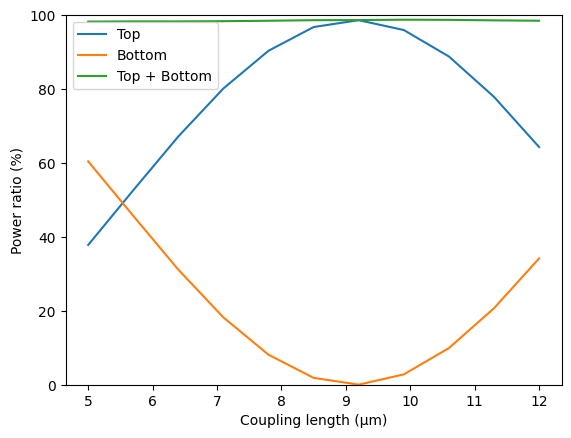

In [16]:
plt.plot(ls, 100 * power_top, label="Top")
plt.plot(ls, 100 * power_bot, label="Bottom")
plt.plot(ls, 100 * power_out, label="Top + Bottom")
plt.xlabel("Coupling length (µm)")
plt.ylabel("Power ratio (%)")
plt.ylim(0, 100)
plt.legend()
plt.show()


### Final Remarks

Batches provide some other convenient functionality for managing large numbers of jobs.

For example, one can save the batch information to file and load the batch at a later time, if needing to disconnect from the service while the jobs are running.

In [17]:
# save batch metadata
batch.to_file("data/batch_data.json")

# load batch metadata into a new batch
loaded_batch = web.Batch.from_file("data/batch_data.json")


For more reference, refer to our documentation.

## Using the `design` Plugin

In `tidy3d` version `2.6.0`, we introduced a `design` plugin, which allows users to programmatically define and run their parameter scans while also providing a convenient container for managing the resulting data.

For more details, please refer to our [full tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Sweep/) on the sweep plugin.

We import the sweep plugin through `tidy3d.plugins.design` below.


In [18]:
import tidy3d.plugins.design as tdd

Then we define our sweep dimensions as `tdd.ParameterFloat` instances and give them each a range.

> Note: we need to ensure that the `name` arguments match the function argument names in our `make_sim()` function, which we will use to construct the simulations for the parameter scan.

In [19]:
param_spc = tdd.ParameterFloat(name="wg_spacing_coup", span=(0.1, 0.15), num_points=3)
param_len = tdd.ParameterFloat(name="coup_length", span=(5, 12), num_points=3)

For this example, we will do a grid search over these points, which we can define a `tdd.MethodGrid` and then combine everything into a `tdd.DesignSpace`.

In [20]:
method = tdd.MethodGrid()
design_space = tdd.DesignSpace(parameters=[param_spc, param_len], method=method)

To run the sweep, we need to pass the design space our evaluation function. Here we will define it through pre and post processing functions, which enables the `design` plugin to take advantage of parallelism to perform `Batch` processing under the hood.

The functions `make_sim` and `measure_transmission` already almost work perfectly as pre and post processing functions. We'll just wrap `measure_transmission` to return a dictionary of the amplitudes, so that the dictionary keys can be used to label the outputs in the resulting dataset.

In [21]:
def fn_post(*args, **kwargs):
    """Post processing function, but label the outputs using a dictionary."""
    a, b, c, d = measure_transmission(*args, **kwargs)
    return dict(input=a, reflect_bottom=b, top=c, bottom=d)

Finally, we pass our pre-processing and post-processing functions to the `DesignSpace.run_batch()` method to get our results.

In [22]:
results = design_space.run_batch(fn_pre=make_sim, fn_post=fn_post)

23:23:38 PST Created task '{'wg_spacing_coup': 0.1, 'coup_length': 5.0}' with   
             task_id 'fdve-01a83e20-930f-4485-9241-99ad4169d313' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=719479;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01a83e20-930f-4485-9241-99ad4169d313\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=744465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01a83e20-930f-4485-9241-99ad4169d313\taskId]8;;\]8;id=719479;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01a83e20-930f-4485-9241-99ad4169d313\=]8;;\]8;id=146529;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01a83e20-930f-4485-9241-99ad4169d313\fdve]8;;\]8;id=719479;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01a83e20-930f-4485-9241-99ad4169d313\-01a83e20-930]8;;\
             ]8;id=719479;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01a83e20-930f-4485-9241-99ad4169d313\f-4485-9241-99ad4169d313']8;;\.

Output()

23:23:39 PST Created task '{'wg_spacing_coup': 0.125, 'coup_length': 5.0}' with 
             task_id 'fdve-174dcc15-159f-404c-b058-70ee576e2918' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=890965;https://tidy3d.simulation.cloud/workbench?taskId=fdve-174dcc15-159f-404c-b058-70ee576e2918\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=763447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-174dcc15-159f-404c-b058-70ee576e2918\taskId]8;;\]8;id=890965;https://tidy3d.simulation.cloud/workbench?taskId=fdve-174dcc15-159f-404c-b058-70ee576e2918\=]8;;\]8;id=455536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-174dcc15-159f-404c-b058-70ee576e2918\fdve]8;;\]8;id=890965;https://tidy3d.simulation.cloud/workbench?taskId=fdve-174dcc15-159f-404c-b058-70ee576e2918\-174dcc15-159]8;;\
             ]8;id=890965;https://tidy3d.simulation.cloud/workbench?taskId=fdve-174dcc15-159f-404c-b058-70ee576e2918\f-404c-b058-70ee576e2918']8;;\.

Output()

             Created task '{'wg_spacing_coup': 0.15, 'coup_length': 5.0}' with  
             task_id 'fdve-92243161-42de-4037-ba06-7a4cfe7b5752' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=252062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92243161-42de-4037-ba06-7a4cfe7b5752\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=690558;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92243161-42de-4037-ba06-7a4cfe7b5752\taskId]8;;\]8;id=252062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92243161-42de-4037-ba06-7a4cfe7b5752\=]8;;\]8;id=910432;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92243161-42de-4037-ba06-7a4cfe7b5752\fdve]8;;\]8;id=252062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92243161-42de-4037-ba06-7a4cfe7b5752\-92243161-42d]8;;\
             ]8;id=252062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92243161-42de-4037-ba06-7a4cfe7b5752\e-4037-ba06-7a4cfe7b5752']8;;\.

Output()

23:23:40 PST Created task '{'wg_spacing_coup': 0.1, 'coup_length': 8.5}' with   
             task_id 'fdve-bf6764ef-159c-4f7b-a22e-e3a8c93e04df' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=566051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf6764ef-159c-4f7b-a22e-e3a8c93e04df\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=732755;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf6764ef-159c-4f7b-a22e-e3a8c93e04df\taskId]8;;\]8;id=566051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf6764ef-159c-4f7b-a22e-e3a8c93e04df\=]8;;\]8;id=294776;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf6764ef-159c-4f7b-a22e-e3a8c93e04df\fdve]8;;\]8;id=566051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf6764ef-159c-4f7b-a22e-e3a8c93e04df\-bf6764ef-159]8;;\
             ]8;id=566051;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bf6764ef-159c-4f7b-a22e-e3a8c93e04df\c-4f7b-a22e-e3a8c93e04df']8;;\.

Output()

             Created task '{'wg_spacing_coup': 0.125, 'coup_length': 8.5}' with 
             task_id 'fdve-bb5d30ef-658a-49fd-a929-cdd226ad51f1' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=976095;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb5d30ef-658a-49fd-a929-cdd226ad51f1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=503324;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb5d30ef-658a-49fd-a929-cdd226ad51f1\taskId]8;;\]8;id=976095;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb5d30ef-658a-49fd-a929-cdd226ad51f1\=]8;;\]8;id=765859;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb5d30ef-658a-49fd-a929-cdd226ad51f1\fdve]8;;\]8;id=976095;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb5d30ef-658a-49fd-a929-cdd226ad51f1\-bb5d30ef-658]8;;\
             ]8;id=976095;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb5d30ef-658a-49fd-a929-cdd226ad51f1\a-49fd-a929-cdd226ad51f1']8;;\.

Output()

23:23:41 PST Created task '{'wg_spacing_coup': 0.15, 'coup_length': 8.5}' with  
             task_id 'fdve-95c985b7-29d3-481e-9038-aafefa6dc03a' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=991304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-95c985b7-29d3-481e-9038-aafefa6dc03a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=972320;https://tidy3d.simulation.cloud/workbench?taskId=fdve-95c985b7-29d3-481e-9038-aafefa6dc03a\taskId]8;;\]8;id=991304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-95c985b7-29d3-481e-9038-aafefa6dc03a\=]8;;\]8;id=564451;https://tidy3d.simulation.cloud/workbench?taskId=fdve-95c985b7-29d3-481e-9038-aafefa6dc03a\fdve]8;;\]8;id=991304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-95c985b7-29d3-481e-9038-aafefa6dc03a\-95c985b7-29d]8;;\
             ]8;id=991304;https://tidy3d.simulation.cloud/workbench?taskId=fdve-95c985b7-29d3-481e-9038-aafefa6dc03a\3-481e-9038-aafefa6dc03a']8;;\.

Output()

             Created task '{'wg_spacing_coup': 0.1, 'coup_length': 12.0}' with  
             task_id 'fdve-aea73490-6c6e-4854-914f-4c3526c6ff85' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=979591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aea73490-6c6e-4854-914f-4c3526c6ff85\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=499754;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aea73490-6c6e-4854-914f-4c3526c6ff85\taskId]8;;\]8;id=979591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aea73490-6c6e-4854-914f-4c3526c6ff85\=]8;;\]8;id=756249;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aea73490-6c6e-4854-914f-4c3526c6ff85\fdve]8;;\]8;id=979591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aea73490-6c6e-4854-914f-4c3526c6ff85\-aea73490-6c6]8;;\
             ]8;id=979591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aea73490-6c6e-4854-914f-4c3526c6ff85\e-4854-914f-4c3526c6ff85']8;;\.

Output()

             Created task '{'wg_spacing_coup': 0.125, 'coup_length': 12.0}' with
             task_id 'fdve-fb98bd88-da4e-4f99-b381-a74c2c121b23' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=749540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb98bd88-da4e-4f99-b381-a74c2c121b23\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=187134;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb98bd88-da4e-4f99-b381-a74c2c121b23\taskId]8;;\]8;id=749540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb98bd88-da4e-4f99-b381-a74c2c121b23\=]8;;\]8;id=954636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb98bd88-da4e-4f99-b381-a74c2c121b23\fdve]8;;\]8;id=749540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb98bd88-da4e-4f99-b381-a74c2c121b23\-fb98bd88-da4]8;;\
             ]8;id=749540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb98bd88-da4e-4f99-b381-a74c2c121b23\e-4f99-b381-a74c2c121b23']8;;\.

Output()

23:23:42 PST Created task '{'wg_spacing_coup': 0.15, 'coup_length': 12.0}' with 
             task_id 'fdve-aa5e9ef3-eaa3-4ff8-bf76-88e8f62aa6a9' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=768898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa5e9ef3-eaa3-4ff8-bf76-88e8f62aa6a9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=350954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa5e9ef3-eaa3-4ff8-bf76-88e8f62aa6a9\taskId]8;;\]8;id=768898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa5e9ef3-eaa3-4ff8-bf76-88e8f62aa6a9\=]8;;\]8;id=458365;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa5e9ef3-eaa3-4ff8-bf76-88e8f62aa6a9\fdve]8;;\]8;id=768898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa5e9ef3-eaa3-4ff8-bf76-88e8f62aa6a9\-aa5e9ef3-eaa]8;;\
             ]8;id=768898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa5e9ef3-eaa3-4ff8-bf76-88e8f62aa6a9\3-4ff8-bf76-88e8f62aa6a9']8;;\.

Output()

23:23:46 PST Started working on Batch.

23:23:50 PST Maximum FlexCredit cost: 5.102 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

23:25:20 PST Batch complete.

Output()

23:25:21 PST loading simulation from                                            
             ./fdve-01a83e20-930f-4485-9241-99ad4169d313.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

23:25:22 PST loading simulation from                                            
             ./fdve-174dcc15-159f-404c-b058-70ee576e2918.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

             loading simulation from                                            
             ./fdve-92243161-42de-4037-ba06-7a4cfe7b5752.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

23:25:23 PST loading simulation from                                            
             ./fdve-bf6764ef-159c-4f7b-a22e-e3a8c93e04df.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

             loading simulation from                                            
             ./fdve-bb5d30ef-658a-49fd-a929-cdd226ad51f1.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:25:24 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

             loading simulation from                                            
             ./fdve-95c985b7-29d3-481e-9038-aafefa6dc03a.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

23:25:25 PST loading simulation from                                            
             ./fdve-aea73490-6c6e-4854-914f-4c3526c6ff85.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

             loading simulation from                                            
             ./fdve-fb98bd88-da4e-4f99-b381-a74c2c121b23.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

23:25:26 PST loading simulation from                                            
             ./fdve-aa5e9ef3-eaa3-4ff8-bf76-88e8f62aa6a9.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Let's get a `pandas.DataFrame` of the results and print out the first 5 elements.

In [23]:
df = results.to_dataframe()

# take absolute value squared of output 2 to get powers to the top port
df['amp_squared_top'] = df['top'].map(lambda x: abs(x)**2)

df.head()

,wg_spacing_coup,coup_length,input,reflect_bottom,top,bottom,amp_squared_top
0,0.100,5.0,-0.006878+0.000155j,0.007611-0.001430j,0.446993+0.422390j,0.536557-0.562449j,0.378217
1,0.125,5.0,-0.011013-0.001935j,0.009946-0.000710j,0.287411+0.180854j,0.500121-0.786399j,0.115313
2,0.150,5.0,-0.003424+0.001328j,0.008498+0.000748j,0.075504+0.033292j,0.413470-0.898602j,0.006809
3,0.100,8.5,-0.003933+0.003567j,0.002067-0.002686j,0.328941+0.927132j,0.128453-0.045006j,0.967775
4,0.125,8.5,0.002186+0.004294j,-0.003497-0.002464j,0.465280+0.695997j,0.444890-0.297377j,0.700896


And we can also use `DataFrame` visualization methods, documented [here](https://pandas.pydata.org/docs/user_guide/visualization.html). 

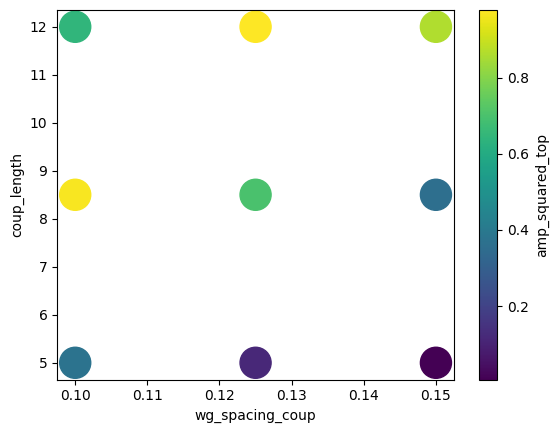

In [24]:
df.plot.scatter(x="wg_spacing_coup", y="coup_length", c="amp_squared_top", s=500)
plt.show()

If you are interested in this approach to parmaeter sweeps, we highly recommend checking our our `design` plugin [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/) for a deep dive and also the [documentation](https://pandas.pydata.org/docs/getting_started/intro_tutorials/01_table_oriented.html#min-tut-01-tableoriented) for `pandas.DataFrame`.

## Parameter Scan using Signac

For users who might need more structure to their parameter scans, the open source tool "[signac](https://signac.io)" is a fantastic resource. Here we will reproduce some of the previous parameter scan using signac to give an introduction to how to apply it to Tidy3D projects. You can see detailed tutorials and examples at their [documentation page](https://docs.signac.io/en/latest/tutorial.html).

After importing the package, we need to define a `project`, which also tells `signac` to store our parameter scan data in a local directory of our choice.

In [25]:
import signac

# make the project and give it a path to save the data into
project = signac.init_project(path="data/coupler")

With `siganc` (and more generally in parameter sweeps), it is very useful to have a single function to define the inputs and outputs of your parameter scan. In our case, we have a single input (coupling length `l`) and two outputs: coupling efficiency (`eff`) and the split ratio (`ratio`). We write a function to link these inputs and outputs through a Tidy3D simulation.

In [26]:
def compute(l: float):
    """compute efficiency and split ratio as a function of the coupling length"""
    sim = make_sim(l, wg_spacing_coup)
    task_name = f"SWEEP_l={l:.3f}"
    sim_data = web.run(sim, task_name=task_name, verbose=False)
    amps_arms = np.array(measure_transmission(sim_data))
    powers = np.abs(amps_arms)**2
    efficiency = np.sum(powers)
    ratio_0 = powers[2] / efficiency
    return efficiency, ratio_0

The `signac` `project` contains a set of `job` objects, which each define a specific data point of our parameter scan. As such, we define another function that wraps `compute` but instead simply accepts a `job` instance, which makes our lives easier for managing parameter sweeps in `signac`.

This function basically will open a job, grab its inputs (`l` value in our case), compute the output quantities, and save them to both the `job.document` record and also the `.txt` files storing the parameter scan results.

In [27]:
def compute_transmission(job):
    l = job.statepoint()["l"]
    print(f"Computing transmission of job: [l={l:.1f}]", job)
    eff, ratio = compute(**job.statepoint())
    job.document["eff"] = float(eff)
    job.document["ratio"] = float(ratio)
    with open(job.fn("eff.txt"), "w") as file:
        file.write(str(float(eff)) + "\n")
    with open(job.fn("ratio.txt"), "w") as file:
        file.write(str(float(ratio)) + "\n")

With this, we can start our parameter scan, we simply loop through our desired `l` values, construct a `job` for each, and pass it to our `compute_transmission` function.

> Note: If intermediate simulation results are needed, it should be possible to modify `compute` to return also the `SimulationData` associated with our task, which we could then store in the `job.document` or elsewhere.

We will compute only 3 values between our ranges of 5 and 12 to save time.

> Note, the `job` instances each have their own unique ID, similar to Tidy3D `task_id`, this is what is being printed below with each job being computed.

In [28]:
for l in np.linspace(5, 12, 3):
    statepoint = {"l": float(l)}
    job = project.open_job(statepoint)    
    compute_transmission(job)

Computing transmission of job: [l=5.0] abb6bcf88ee5474914d016b3c1fcc7b3


23:25:29 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Computing transmission of job: [l=8.5] c261dda788d2af5c1645cb17feb7854a


23:25:30 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Computing transmission of job: [l=12.0] bc0f33313f39cc49b60566dcb7f169f9


23:25:31 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Let's take a look at our project and what data we've computed and stored so far.

In [29]:
for job in project:
    print(job.statepoint(), job.document)

{'l': 12.0} {'eff': 0.9848516859759866, 'ratio': 0.6529555565355277}
{'l': 8.5} {'eff': 0.9863408672001608, 'ratio': 0.9811774519950235}
{'l': 5.0} {'eff': 0.9825664786349806, 'ratio': 0.3849273096886306}


`signac` also provides the ability to create a "[linked view](https://docs.signac.io/en/latest/examples/notebooks/signac_102_Exploring_Data.html#1.2-Exploring-Data)", which gives us a human-readable filesystem for looking at our jobs.

In [30]:
project.create_linked_view(prefix="data/coupler/view")

# let's print out some info stored in the directory we just created
!ls data/coupler/view/l/
!ls data/coupler/view/l/5.0/job/
!cat data/coupler/view/l/5.0/job/eff.txt

12.0  5.0  8.5


eff.txt  ratio.txt  signac_job_document.json  signac_statepoint.json


0.9825664786349806


We can also initialize many data points to compute later, and feed them to the `compute_transmission` function with a very basic "caching" implemented by checking if our inputs already exist in the record.

In [31]:
def init_statepoints(n):
    for l in np.linspace(5, 12, n):
        sp = {"l": float(l)}
        job = project.open_job(sp)
        job.init()
        print("initialize", job)

# make 5 points between 5 and 12, note, 3 have already been computed
init_statepoints(5)

initialize abb6bcf88ee5474914d016b3c1fcc7b3
initialize 07222394eb1a1b59f9e869ef871a3c29
initialize c261dda788d2af5c1645cb17feb7854a
initialize bdbbc3c4500db5773fa3cd350b6195ed
initialize bc0f33313f39cc49b60566dcb7f169f9


After initializing our statepoints (input values), they are stored in our project and we can loop through them and compute any that don't have records.

In [32]:
for job in project:
    if "eff" not in job.document or "ratio" not in job.document:
        compute_transmission(job)
    else:
        print(f" - skipping job: {job} ")

 - skipping job: bc0f33313f39cc49b60566dcb7f169f9 
Computing transmission of job: [l=6.8] 07222394eb1a1b59f9e869ef871a3c29


23:27:00 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

 - skipping job: c261dda788d2af5c1645cb17feb7854a 
 - skipping job: abb6bcf88ee5474914d016b3c1fcc7b3 
Computing transmission of job: [l=10.2] bdbbc3c4500db5773fa3cd350b6195ed


23:28:39 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

While we used `td.web.Batch` in our original example, `signac` lets us also leverage parallel processing tools in python to perform something similar.

Let's initialize 9 total statepoints now (5 have already been computed) and feed them to a `ThreadPool`. We notice that the jobs will be computed in parallel depending on how many threads are available on your machine.

In [33]:
init_statepoints(9)

from multiprocessing.pool import ThreadPool

# make a convenience function to just call compute_transmission only for uncomputed jobs
def compute_transmission_cached(job):
    if "eff" not in job.document or "ratio" not in job.document:
        compute_transmission(job)

with ThreadPool() as pool:
    pool.map(compute_transmission_cached, list(project))

initialize abb6bcf88ee5474914d016b3c1fcc7b3
initialize dca27bcde6b7bfede0d701809749e789
initialize 07222394eb1a1b59f9e869ef871a3c29
initialize b22f487baf2db695e6b15444d42e31ff
initialize c261dda788d2af5c1645cb17feb7854a
initialize c7a1813a4fd1fd835898df062c3262c9
initialize bdbbc3c4500db5773fa3cd350b6195ed
initialize 9af2b1986858046540a9da68dbf4f425
initialize bc0f33313f39cc49b60566dcb7f169f9
Computing transmission of job: [l=5.9] dca27bcde6b7bfede0d701809749e789
Computing transmission of job: [l=9.4] c7a1813a4fd1fd835898df062c3262c9
Computing transmission of job: [l=7.6] b22f487baf2db695e6b15444d42e31ff
Computing transmission of job: [l=11.1] 9af2b1986858046540a9da68dbf4f425


23:30:08 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:30:10 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:30:20 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

23:30:22 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

In [34]:
for job in project:
    print(job.statepoint(), job.document)

{'l': 5.875} {'eff': 0.982539628473676, 'ratio': 0.57419072017567}
{'l': 7.625} {'eff': 0.9848880316895842, 'ratio': 0.8947585765035918}
{'l': 12.0} {'eff': 0.9848516859759866, 'ratio': 0.6529555565355277}
{'l': 6.75} {'eff': 0.9824397750939875, 'ratio': 0.7526838005816282}
{'l': 11.125} {'eff': 0.9864516484759145, 'ratio': 0.82006380263208}
{'l': 9.375} {'eff': 0.9873991199611547, 'ratio': 0.9971435292136205}
{'l': 8.5} {'eff': 0.9863408672001608, 'ratio': 0.9811774519950235}
{'l': 5.0} {'eff': 0.9825664786349806, 'ratio': 0.3849273096886306}
{'l': 10.25} {'eff': 0.9870632237735698, 'ratio': 0.9402363173237896}


Finally, we can consolidate and plot our results.

In [35]:
ls =  np.array([job.statepoint()["l"] for job in project])
effs = np.array([job.document["eff"] for job in project])
ratios = np.array([job.document["ratio"] for job in project])

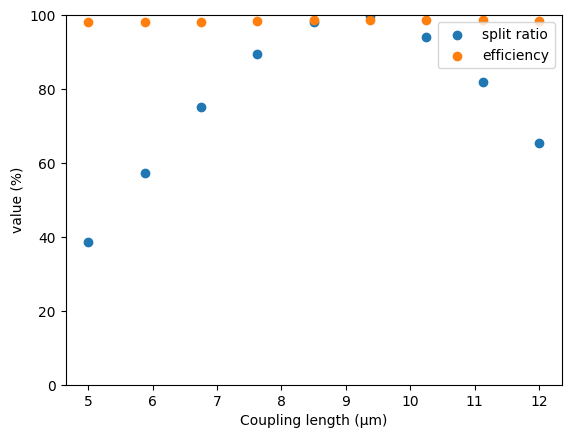

In [36]:
plt.scatter(ls, 100 * ratios, label="split ratio")
plt.scatter(ls, 100 * effs, label="efficiency")
plt.xlabel("Coupling length (µm)")
plt.ylabel("value (%)")
plt.ylim(0, 100)
plt.legend()
plt.show()


For more information, we highly recommend you visit `signac` [documentation page](https://docs.signac.io/en/latest), which includes explanations about all of the many other features not covered here, which could assist you in your parameter scans using Tidy3D.